In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [74]:
import csv
import cv2
import json
import random

from pathlib import Path
from collections import defaultdict
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
import torch.autograd as autograd

In [4]:
PATH = Path('../data/')

In [5]:
list(PATH.iterdir())

[PosixPath('../data/leaderboard_test_data'),
 PosixPath('../data/train_images'),
 PosixPath('../data/leaderboard_holdout_data'),
 PosixPath('../data/mode_tmp.pth'),
 PosixPath('../data/SampleSubmission.csv'),
 PosixPath('../data/traininglabels.csv')]

In [6]:
train_labels = pd.read_csv(str(PATH/'traininglabels.csv'))

In [7]:
train_labels.head(5)

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [8]:
np.sum(train_labels['has_oilpalm'])

942

In [9]:
len(train_labels)

15244

In [10]:
np.sum(train_labels['has_oilpalm'])/len(train_labels)

0.06179480451325112

# Check train images

In [11]:
def load_image(img_path):
    img = cv2.imread(str(img_path)).astype(np.float32)/255
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

def show_image(paths, nrow=2, ncol=3):
    n = nrow * ncol
    fig, axes = plt.subplots(nrow, ncol, figsize=(12, 8))
    
    for i, ax in enumerate(axes.flat):
        img = load_image(paths[i][0])
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if paths[i][1] == 0:
            ax.set_title(f'No oil palm trees, label score is {paths[i][2]}')
        else:
            ax.set_title(f'Has oil palm trees, label score is {paths[i][2]}')
    
    plt.tight_layout()

In [12]:
img_names = random.sample(list(train_labels['image_id']), 6)
img_labels = [train_labels.loc[train_labels['image_id'] == p, 'has_oilpalm'].values[0] for p in img_names]
label_score = [train_labels.loc[train_labels['image_id'] == p, 'score'].values[0] for p in img_names]

img_paths = [(str(PATH/f"train_images/{p}"), l, s) for p, l, s in zip(img_names, img_labels, label_score)]
img_paths

[('../data/train_images/img_078872017.jpg', 0, 1.0),
 ('../data/train_images/img_088662017.jpg', 0, 1.0),
 ('../data/train_images/img_105792017.jpg', 0, 1.0),
 ('../data/train_images/img_063602018.jpg', 0, 0.7856),
 ('../data/train_images/img_109612018.jpg', 0, 0.7974),
 ('../data/train_images/img_023422017.jpg', 0, 1.0)]

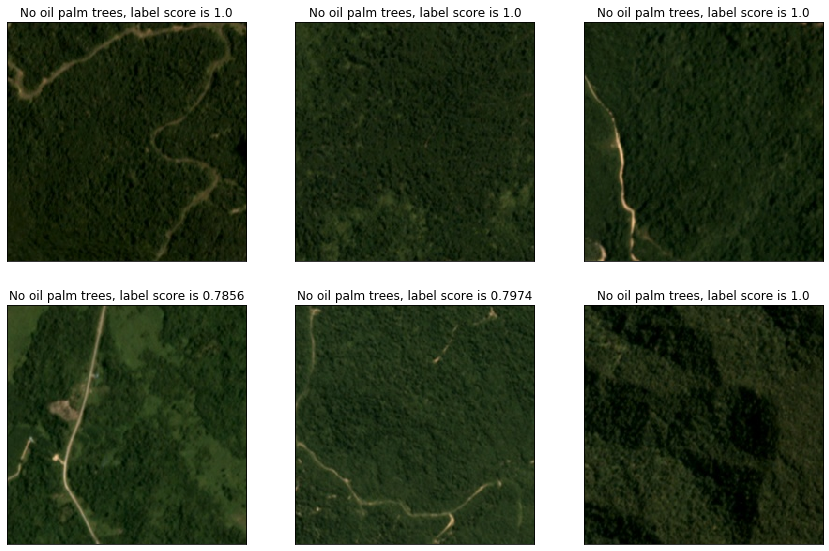

In [13]:
show_image(img_paths)

# Data Loader

In [14]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [15]:
# all images are 256x256, so no need to resize
# img_size = 224
batch_size = 64

In [16]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

def denormalize(im):
    """Denormalizes images."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im * imagenet_stats[1]) + imagenet_stats[0]

## Data augmentation

In [17]:
# add transformations

## Dataset

In [59]:
class oilPalmDataset(Dataset):
    def __init__(self, dataset, transform=False, test=False):
        self.dataset = dataset[:, 0]
        self.test = test
#         self.transforms = transforms
        if not self.test:
            self.y = dataset[:, 1]
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, i):
        path = self.dataset[i]
        X = load_image(path)
        X = normalize(X)
        X = X.transpose(2, 0, 1)
        if not self.test:
            y = int(self.y[i])
            return X, y
        else:
            return X, str(path).split('/')[-1]

In [19]:
X = list(train_labels.loc[:, 'image_id'])
X = [str(PATH/f"train_images/{p}") for p in X]
y = list(train_labels.loc[:, 'has_oilpalm'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Since the training set is unbalanced, let's check if the train/valid dataset is stratified

In [20]:
np.sum(y_train)/(len(y)*.8)

0.06231960115455261

In [21]:
np.sum(y_val)/(len(y)*.2)

0.05969561794804513

## Make data loader

In [22]:
train = np.concatenate([np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1)], axis=1)
valid = np.concatenate([np.array(X_val).reshape(-1, 1), np.array(y_val).reshape(-1, 1)], axis=1)

In [23]:
train = oilPalmDataset(train)
valid = oilPalmDataset(valid)

In [24]:
train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid, batch_size=batch_size)

In [25]:
X, y = next(iter(train_dl))
X.shape, y.shape

(torch.Size([64, 3, 256, 256]), torch.Size([64]))

# Modelling

In [27]:
class Net(nn.Module):
    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.out = 512
        self.bn1 = nn.BatchNorm1d(self.out)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(self.out, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        #x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        #x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [28]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim


def LR_range_finder(model, train_dl, lr_low=1e-6, lr_high=1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x, y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses 


def save_model(m, p): 
    torch.save(m.state_dict(), p)
    
def load_model(m, p): 
    m.load_state_dict(torch.load(p))

In [27]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl)

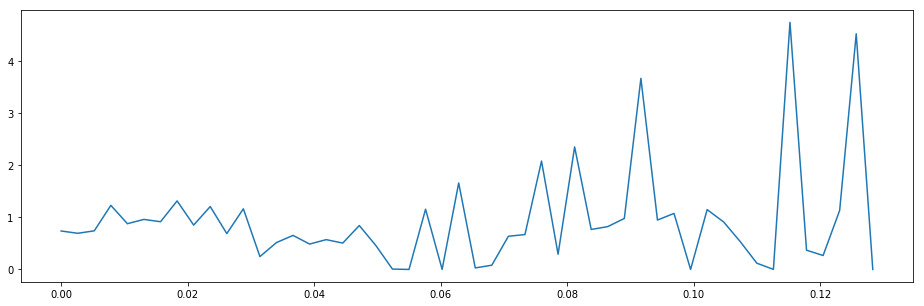

In [28]:
plt.figure(figsize=(16, 5))
plt.plot(lrs[:50], losses[:50])
plt.show()

In [29]:
def get_triangular_lr2(lr_low, lr_high, stepesize):
    iterations = 2*stepesize
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

In [30]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-6, lr_high=0.1):
    idx = 0
    epochs = 4
    stepesize = 2*len(train_dl)
    lrs = get_triangular_lr2(lr_low, lr_high, stepesize)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss %.3f" % (sum_loss/total))
        val_metrics(model, valid_dl)
    return sum_loss/total

In [31]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss %.3f and accuracy score %.3f" % (sum_loss/total, correct/total))

In [32]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, steps=3, lr_low=1e-6, lr_high=0.1):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [33]:
model = Net().cuda()

In [34]:
# before training
val_metrics(model, valid_dl)

val loss 0.715 and accuracy score 0.154


In [35]:
training_loop(model, train_dl, valid_dl, steps=1, lr_low=1e-6, lr_high=4e-3)

train loss 0.255
val loss 0.084 and accuracy score 0.982
train loss 0.075
val loss 0.086 and accuracy score 0.985
train loss 0.051
val loss 0.075 and accuracy score 0.987
train loss 0.046
val loss 0.061 and accuracy score 0.987
----End of step Time elapsed 0:07:02.482429


In [44]:
p = "./baseline-model-98.pth"
save_model(model, p)

# Check validation result

In [31]:
p = "./baseline-model-98.pth"
model = Net().cuda()
model.load_state_dict(torch.load(p))

In [52]:
val_out = []

model.eval()
for X, y in valid_dl:
    X = X.float().cuda()
    y_hat = model(X)
    _, pred = torch.max(y_hat, 1)
    val_out.append(pred)

In [53]:
val_X = []
val_y = []
for X, y in valid_dl:
    val_X.append(X)
    val_y.append(y)

In [54]:
val_out = [t.cpu().numpy() for t in val_out]
val_out = np.concatenate(val_out).ravel()
val_y = np.concatenate(val_y).ravel()

In [63]:
val_y.shape, val_out.shape

((3049,), (3049,))

In [74]:
np.sum(val_y)

182

In [72]:
diff_idx = np.where(~np.equal(val_out, val_y))[0]
diff_idx

array([ 199,  307,  353,  471,  480,  500,  607,  659,  665,  700,  705,
        740,  834,  853, 1010, 1087, 1114, 1164, 1195, 1196, 1260, 1309,
       1427, 1465, 1783, 1918, 1989, 2018, 2116, 2301, 2445, 2590, 2692,
       2726, 2886, 2900, 2903, 2983, 3007])

In [73]:
for idx in diff_idx:
    print(f'Truth: {val_y[idx]}, prediction: {val_out[idx]}')

Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 0, prediction: 1
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 0, prediction: 1
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 0, prediction: 1
Truth: 0, prediction: 1
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 0, prediction: 1
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 1, prediction: 0
Truth: 0, prediction: 1
Truth: 0, prediction: 1
Truth: 0, prediction: 1
Truth: 0, prediction: 1
Truth: 1, prediction: 0
Truth: 0, prediction: 1


# Test

In [60]:
TEST_PATH = PATH/'leaderboard_test_data'

In [61]:
X_test_path = np.array(list(TEST_PATH.iterdir())).reshape(-1, 1)
X_test_path[:5, 0]

array([PosixPath('../data/leaderboard_test_data/img_006952017.jpg'),
       PosixPath('../data/leaderboard_test_data/img_050972018.jpg'),
       PosixPath('../data/leaderboard_test_data/img_078702018.jpg'),
       PosixPath('../data/leaderboard_test_data/img_043442017.jpg'),
       PosixPath('../data/leaderboard_test_data/img_061632017.jpg')],
      dtype=object)

In [62]:
len(X_test_path)

4356

In [63]:
test = oilPalmDataset(X_test_path, test=True)
test_dl = DataLoader(test, batch_size=batch_size)

In [64]:
X, paths = next(iter(test))
X.shape, paths

((3, 256, 256), 'img_006952017.jpg')

In [81]:
p = "./baseline-model-98.pth"
model = Net().cuda()
model.load_state_dict(torch.load(p))

In [82]:
out = []
fpaths = []

model.eval()
for X, path in test_dl:
    X = X.float().cuda()
    y_hat = model(X)
    _, pred = torch.max(y_hat, 1)
    out.append(pred)
    fpaths.append(path)

In [83]:
out = [t.cpu().numpy() for t in out]
out = np.concatenate(out).ravel()
fpaths = np.concatenate(fpaths).ravel()

In [84]:
out

array([0, 0, 0, ..., 0, 0, 0])

In [85]:
fpaths

array(['img_006952017.jpg', 'img_050972018.jpg', 'img_078702018.jpg', ...,
       'img_092222017.jpg', 'img_018762018.jpg', 'img_108412017.jpg'],
      dtype='<U17')

In [86]:
pred_out = sorted(list(zip(fpaths, out)), key=lambda x: x[0])

with open('test_output.csv','w') as f:
    csv_out = csv.writer(f)
    csv_out.writerow(['image_id', 'has_oilpalm'])
    for row in pred_out:
        csv_out.writerow(row)